# Deep Image Segmentation with Convolutional Neural Networks (CNNs)

## Image segmentation

Here, we focus on using Convolutional Neural Networks or CNNs for segmenting images.  Specifically, we use Python and Keras (with TensorFlow as backend) to implement a CNN capable of segmenting lungs in CT scan images with ~94% accuracy.

## Convolutional neural networks

CNNs are a special kind of neural network inspired by the brain’s visual cortex.  So it should come as no surprise that they excel at visual tasks.  CNNs have layers.  Each layer learns higher-level features from the previous layer.  This layered architecture is analogous to how, in the visual cortex, higher-level neurons react to higher-level patterns that are combinations of lower-level patterns generated by lower-level neurons.  Also, unlike traditional Artificial Neural Networks or ANNs, which typically consist of fully connected layers, CNNs consist of partially connected layers.  In fact, in CNNs, neurons in one layer typically only connect to a few neighboring neurons from the previous layer.  This partially connected architecture is analogous to how so-called cortical neurons in the visual cortex only react to stimuli in their receptive fields, which overlap to cover the entire visual field.  Partial connectivity has computational benefits as well, since, with fewer connections, fewer weights need to be learned during training.  This allows CNNs to handle larger images than traditional ANNs.

## Import libraries and initialize Keras

In [18]:
import os
import numpy as np
np.random.seed(123)
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D
from keras.utils import np_utils
from skimage.io import imread
from sklearn.model_selection import train_test_split

In [19]:
# set channels first notation
K.set_image_dim_ordering('th')

## Importing, downsampling, and visualizing data

In [20]:
# Get paths to all images and masks.
all_image_paths = glob('E:\\data\\lungs\\2d_images\\*.tif')
all_mask_paths = glob('E:\\data\\lungs\\2d_masks\\*.tif')
print(len(all_image_paths), 'image paths found')
print(len(all_mask_paths), 'mask paths found')

267 image paths found
267 mask paths found


In [21]:
# Define function to read in and downsample an image.
def read_image (path, sampling=1): return np.expand_dims(imread(path)[::sampling, ::sampling],0)

In [22]:
# Import and downsample all images and masks.
all_images = np.stack([read_image(path, 4) for path in all_image_paths], 0)
all_masks = np.stack([read_image(path, 4) for path in all_mask_paths], 0) / 255.0
print('Image resolution is', all_images[1].shape)
print('Mask resolution is', all_images[1].shape)

Image resolution is (1, 128, 128)
Mask resolution is (1, 128, 128)


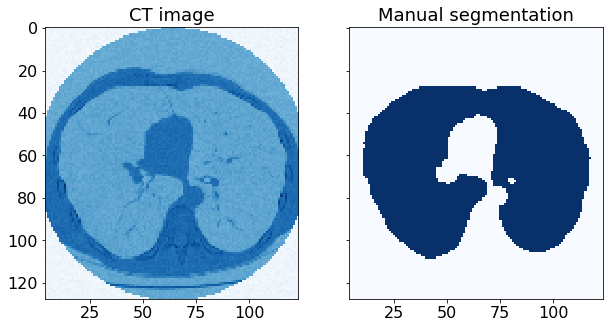

In [23]:
# Visualize an example CT image and manual segmentation. 
example_no = 1
fig, ax = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(10,5))
ax[0].imshow(all_images[example_no, 0], cmap='Blues')
ax[0].set_title('CT image', fontsize=18)
ax[0].tick_params(labelsize=16)
ax[1].imshow(all_masks[example_no, 0], cmap='Blues')
ax[1].set_title('Manual segmentation', fontsize=18)
ax[1].tick_params(labelsize=16)

## Split data into training and validation sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_masks, test_size=0.1)
print('Training input is', X_train.shape)
print('Training output is {}, min is {}, max is {}'.format(y_train.shape, y_train.min(), y_train.max()))
print('Testing set is', X_test.shape)

Training input is (240, 1, 128, 128)
Training output is (240, 1, 128, 128), min is 0.0, max is 1.0
Testing set is (27, 1, 128, 128)


## Create CNN model

In [25]:
# Create a sequential model, i.e. a linear stack of layers.
model = Sequential()

# Add a 2D convolution layer.
model.add(
    Conv2D(
        filters=32, 
        kernel_size=(3, 3), 
        activation='relu', 
        input_shape=all_images.shape[1:],
        padding='same'
    )
)

# Add a 2D convolution layer.
model.add(
    Conv2D(filters=64, 
        kernel_size=(3, 3), 
        activation='sigmoid', 
        input_shape=all_images.shape[1:],
        padding='same'
    )
)

# Add a max pooling layer.
model.add(
    MaxPooling2D(
        pool_size=(2, 2), 
        padding='same'
    )
)

# Add a dense layer.
model.add(
    Dense(
        64, 
        activation='relu'
    )
)

# Add a 2D convolution layer.
model.add(
    Conv2D(
        filters=1, 
        kernel_size=(3, 3), 
        activation='sigmoid', 
        input_shape=all_images.shape[1:],
        padding='same'
    )
)

# Add a 2D upsampling layer.
model.add(
    UpSampling2D(
        size=(2,2)
    )
)

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy','mse']
)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 128, 128)      320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 128, 128)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 64, 64, 64)        4160      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 64, 64)         577       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 1, 128, 128)       0         
Total params: 23,553
Trainable params: 23,553
Non-trainable params: 0
_________________________________________________________________
None


## Train CNN model

In [26]:
history = model.fit(X_train, y_train, validation_split=0.10, epochs=10, batch_size=10)

Train on 216 samples, validate on 24 samples
Epoch 1/10
216/216 [==============================] - 16s 76ms/step - loss: 0.4828 - acc: 0.7601 - mean_squared_error: 0.1615 - val_loss: 0.4325 - val_acc: 0.8377 - val_mean_squared_error: 0.1404
Epoch 2/10
216/216 [==============================] - 12s 53ms/step - loss: 0.3954 - acc: 0.8367 - mean_squared_error: 0.1267 - val_loss: 0.3731 - val_acc: 0.8307 - val_mean_squared_error: 0.1190
Epoch 3/10
216/216 [==============================] - 12s 53ms/step - loss: 0.3505 - acc: 0.8588 - mean_squared_error: 0.1084 - val_loss: 0.3153 - val_acc: 0.8834 - val_mean_squared_error: 0.0949
Epoch 4/10
216/216 [==============================] - 12s 54ms/step - loss: 0.3038 - acc: 0.8868 - mean_squared_error: 0.0901 - val_loss: 0.3118 - val_acc: 0.8613 - val_mean_squared_error: 0.0965
Epoch 5/10
216/216 [==============================] - 12s 53ms/step - loss: 0.2722 - acc: 0.9004 - mean_squared_error: 0.0790 - val_loss: 0.2379 - val_acc: 0.9112 - val_me

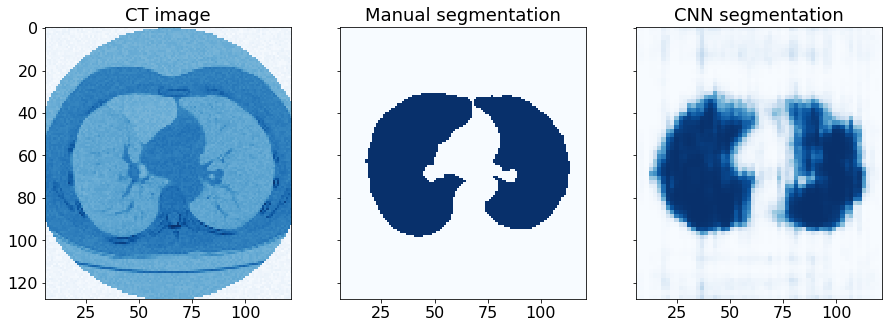

In [33]:
test_no = 7
fig, ax = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row', figsize=(15,5))
ax[0].imshow(X_test[test_no,0], cmap='Blues')
ax[0].set_title('CT image', fontsize=18)
ax[0].tick_params(labelsize=16)
ax[1].imshow(y_test[test_no,0], cmap='Blues')
ax[1].set_title('Manual segmentation', fontsize=18)
ax[1].tick_params(labelsize=16)
ax[2].imshow(model.predict(X_test)[test_no,0], cmap='Blues')
ax[2].set_title('CNN segmentation', fontsize=18)
ax[2].tick_params(labelsize=16)